# Sionna @ IRW'24

Simulation of Sionna (our first rocket) for International Rocket Week 2024 in Scotland.

In [1]:
import datetime
from rocketpy import Environment, SolidMotor, Rocket, Flight

## Setup


### 1 - Environment

Assuming:

- Launch coordinates are estimated within the launch site (give or take 15m)
- Launch day/time is assumed to be the first day
- Elevation got from OpenElevation API 

oc_open: server error retrieving url: code=0 message="/gfs_0p25/gfs20240821/gfs_0p25_18z is not an available dataset"


Gravity Details

Acceleration of gravity at surface level:    9.8154 m/s²
Acceleration of gravity at  79.651 km (ASL): 9.5746 m/s²


Launch Site Details

Launch Date: 2024-08-24 12:00:00 UTC
Launch Site Latitude: 55.72683°
Launch Site Longitude: -4.81092°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 386268.26 W    6177162.75 N
Launch Site UTM zone: 30U
Launch Site Surface Elevation: 89.0 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.651 km
Forecast Time Period: From  2024-08-21 12:00:00  to  2024-09-06 12:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 10.71 m/s
Surface Wind Direction: 245.81°
Surface Wind Heading: 65.81°
Surface Pressure: 992.15 hPa
Surface Temperature: 284.94 K
Surface Air Density: 1.213 kg/m³
Surface Speed of Sound: 338.39 m/s


Earth Model Details

Earth Radius

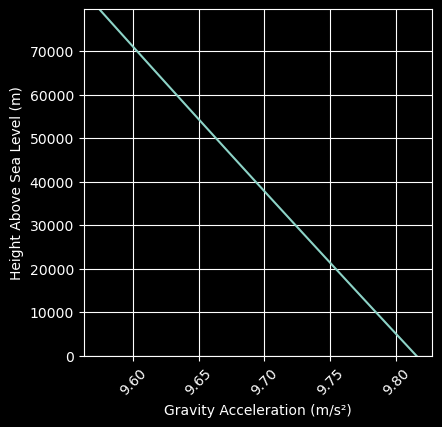



Atmospheric Model Plots


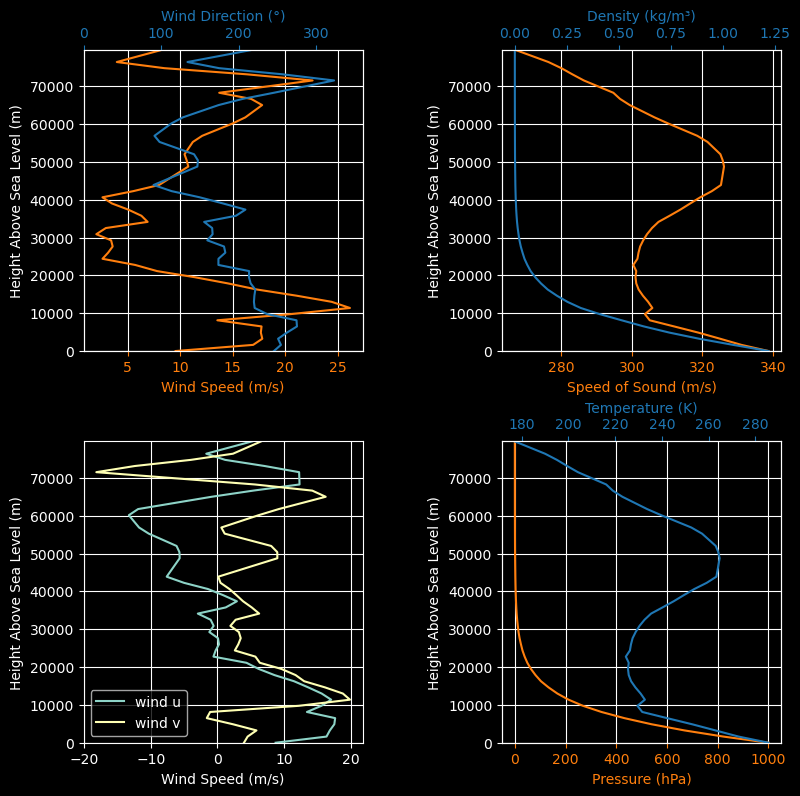

In [2]:
env = Environment(
    latitude=55.726831,
    longitude=-4.810923,
    date=(2024, 8, 24, 12),
)

env.set_atmospheric_model(type="Forecast", file="GFS")
env.all_info()

### 2 - Motor


Nozzle Details
Nozzle Radius: 0.025 m
Nozzle Throat Radius: 0.0125 m

Grain Details
Number of Grains: 2
Grain Spacing: 0.005 m
Grain Density: 1700 kg/m3
Grain Outer Radius: 0.025 m
Grain Inner Radius: 0.01 m
Grain Height: 0.1 m
Grain Volume: 0.000 m3
Grain Mass: 0.280 kg

Motor Details
Total Burning Time: 4.9 s
Total Propellant Mass: 0.561 kg
Average Propellant Exhaust Velocity: 1248.724 m/s
Average Thrust: 142.909 N
Maximum Thrust: 498.166 N at 0.018 s after ignition.
Total Impulse: 700.252 Ns



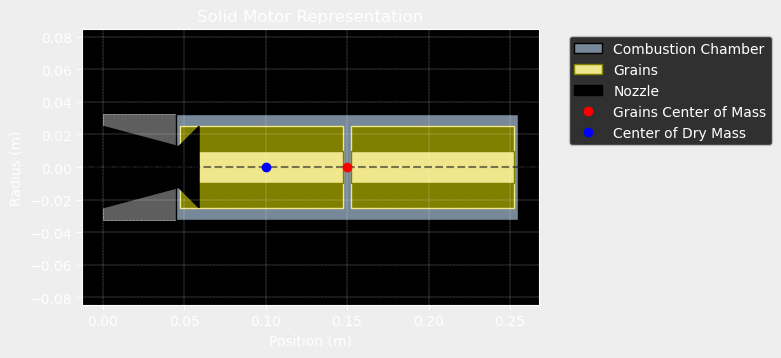

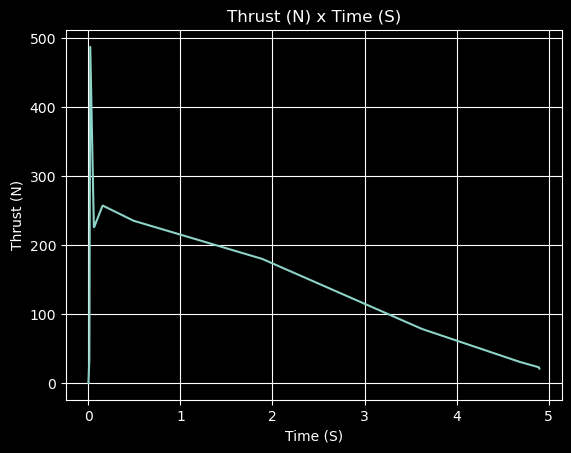

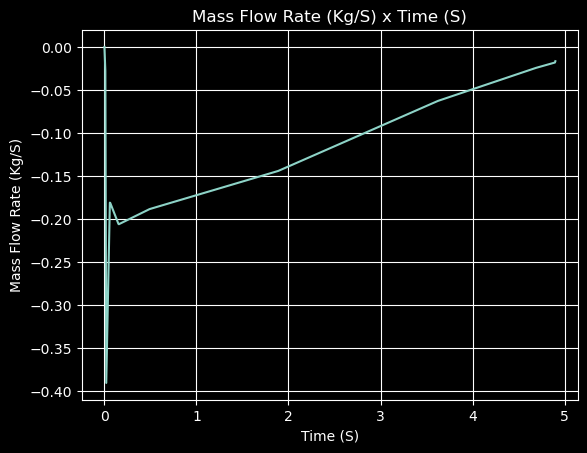

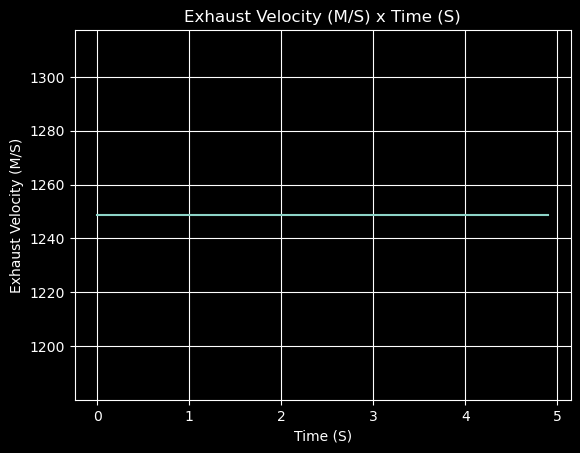

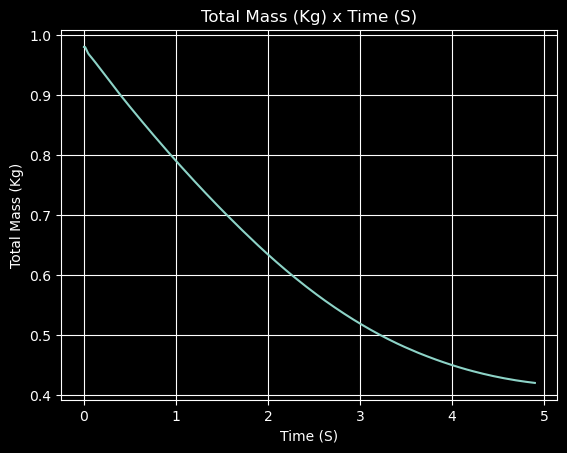

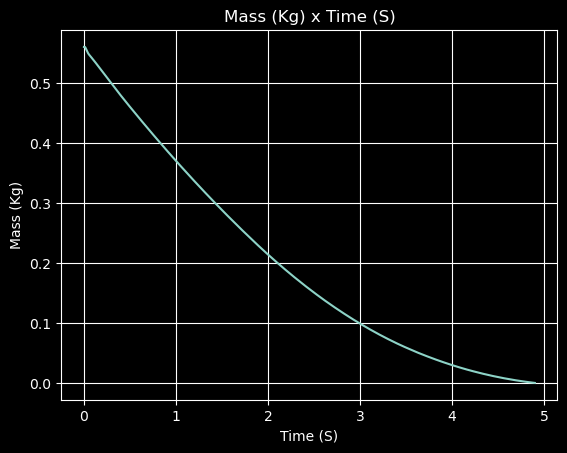

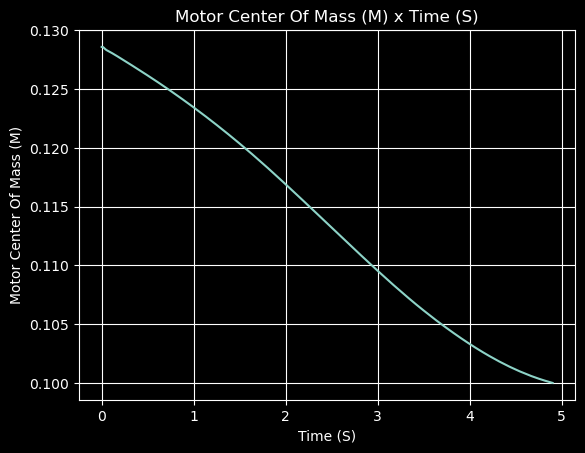

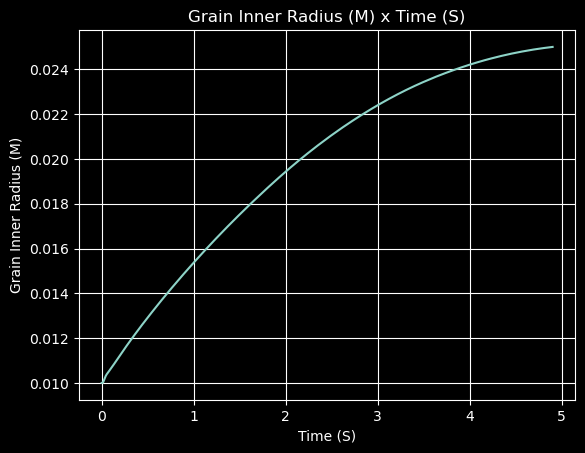

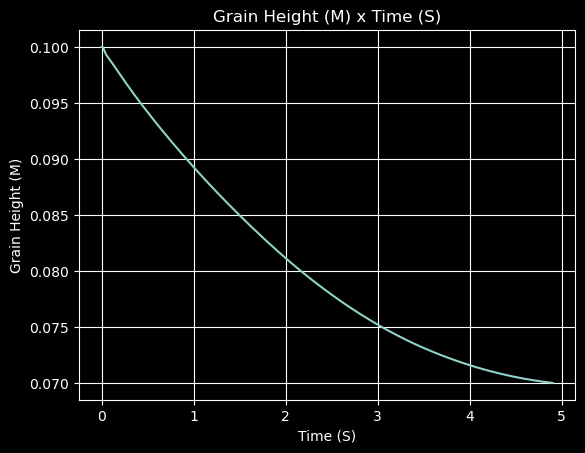

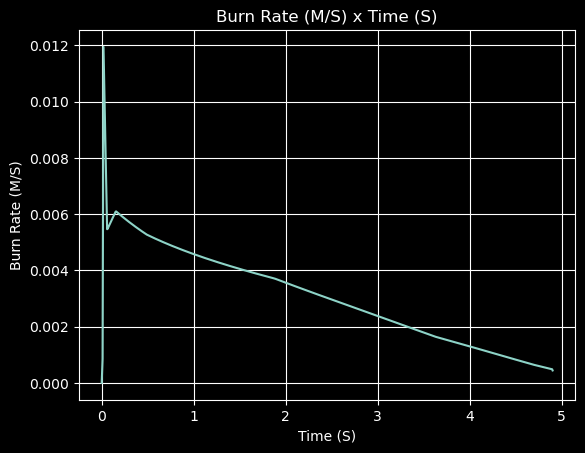

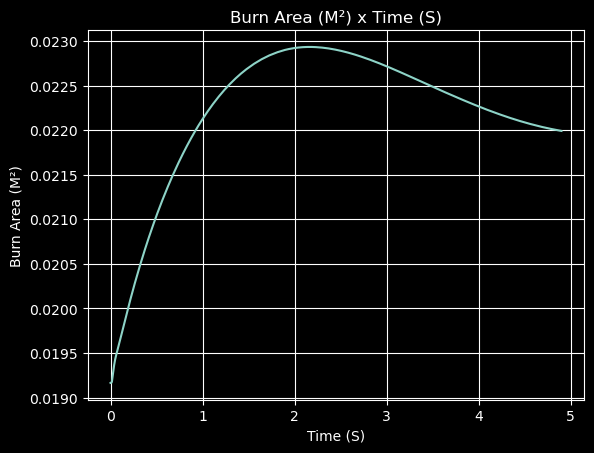

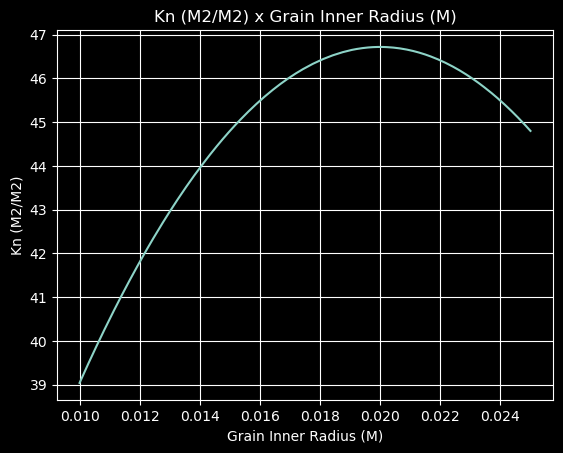

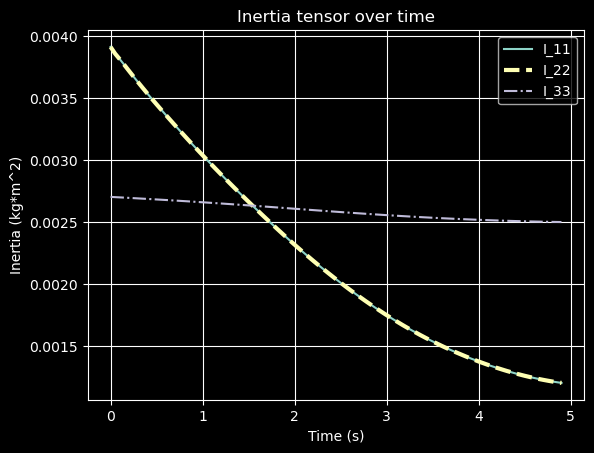

In [3]:
PRO54J145 = SolidMotor(
    thrust_source="assets/motors/Cesaroni_699_J145_SK_LB_19A.eng",
    dry_mass=0.837 - 0.417,  # kilograms (mass of the motor without propellant)
    dry_inertia=(
        0.0012,
        0.0012,
        0.0025,
    ),  # kg*m^2 (Estimated as a typical tuple for moments of inertia: Ix, Iy, Iz)
    nozzle_radius=0.025,  # meters (Estimated typical nozzle exit radius for a 54mm motor)
    grain_number=2,  # Number of propellant grains (from manufacturer specs)
    grain_density=1700,  # kg/m^3 (Typical value for solid propellant used in Cesaroni motors)
    grain_outer_radius=0.025,  # meters (Assuming full use of motor casing minus insulation; typical for 54mm motor)
    grain_initial_inner_radius=0.01,  # meters (Estimate based on typical grain designs; often a fraction of outer radius)
    grain_initial_height=0.1,  # meters (Estimated height of each grain based on motor length and grain number)
    grain_separation=0.005,  # meters (Assuming minimal gap between grains; typical for solid motors)
    grains_center_of_mass_position=0.15,  # meters (Assuming grains are centered within the motor; estimated at mid-length)
    center_of_dry_mass_position=0.1,  # meters (Calculated as length of aft part / total length of motor)
    nozzle_position=0.0,  # relative to the combustion chamber (Origin at the nozzle exit, standard setup)
    burn_time=4.9,  # seconds (From thrust curve data)
    throat_radius=0.0125,  # meters (Estimated throat radius, typically half of nozzle radius in simple converging-diverging nozzles)
    coordinate_system_orientation="nozzle_to_combustion_chamber",  # Orientation of the coordinate system -> EXTREMELY IMPORTANT for correct simulation
)

PRO54J145.all_info()

### 3 - Rocket


In [4]:
rocket = Rocket(
    radius=0.0395,  # (r) body in meters 5.1cm = 0.051m
    mass=2.152,  # kg (dry)
    inertia=(
        0.64,
        0.758,
        0.3,
    ),  # Moments of inertia of the rocket in kg*m^2 (Ix, Iy, Iz) CG is Ix CP is Iy
    power_off_drag="assets/aero/cd_power_off.csv",  # power-off drag curve csv
    power_on_drag="assets/aero/cd_power_on.csv",  # power-on drag curve csv
    center_of_mass_without_motor=43.2 / 100,
    coordinate_system_orientation="tail_to_nose",  # MUST be relative to the coordinate system defined in the motor
)

rail_buttons = rocket.set_rail_buttons(
    upper_button_position=0.45,  # relative to the rocket nozzle
    lower_button_position=0.05,  # relative to the rocket nozzle
    angular_position=180,  # degrees
)

rocket.add_motor(PRO54J145, position=0)

### 4 - Aero surfaces


In [5]:
nose_cone = rocket.add_nose(
    length=0.381, kind="ogive", position=1.31, base_radius=0.0395
)  # length in meters, relative to nozzle

In [6]:
fin_set = rocket.add_fins(
    n=3,
    root_chord=0.2,  # meters
    tip_chord=0.06,  # meters
    span=0.045,  # meters (aka height)
    position=0.2,  # relative to the rocket nose
    cant_angle=0,  # radians
    airfoil=("assets/aero/clv_alpha.csv", "degrees"),
    sweep_length=0.0715,
)

### 5 - Recovery


In [7]:
droguepara = rocket.add_parachute(
    "Drogue",  # name
    cd_s=0.8,  # Drag coefficient of the parachute in m^2
    trigger="apogee",  # altitude in meters OR an event
    sampling_rate=105,
    lag=0,  # seconds (seconds )
    noise=(0, 8.3, 0.5),
)

mainpara = rocket.add_parachute(
    "Main",  # name
    cd_s=1,  # Drag coefficient of the parachute in m^2
    trigger=200,  # altitude in meters OR an event
    sampling_rate=105,
    lag=0,  # seconds
    noise=(0, 8.3, 0.5),
)


Inertia Details

Rocket Mass: 2.152 kg (without motor)
Rocket Dry Mass: 2.572 kg (with unloaded motor)
Rocket Loaded Mass: 3.133 kg (with loaded motor)
Rocket Inertia (with unloaded motor) 11: 0.680 kg*m2
Rocket Inertia (with unloaded motor) 22: 0.798 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.302 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0395 m
Rocket Frontal Area: 0.004902 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.054 m
Rocket Center of Dry Mass - Nozzle Exit: 0.378 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.228 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.041 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Fins Lift Coefficient Derivative: 2.701/rad

Center of Pressure

Nose Cone Center of Pr

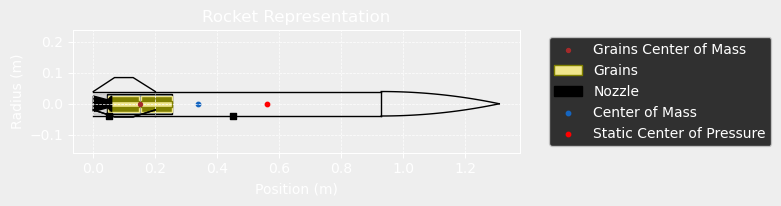


Mass Plots
----------------------------------------


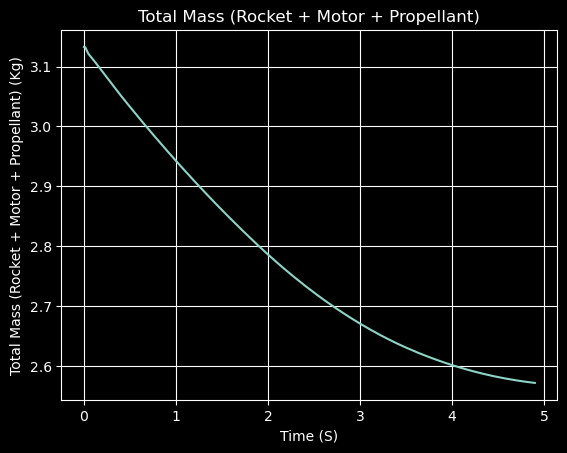

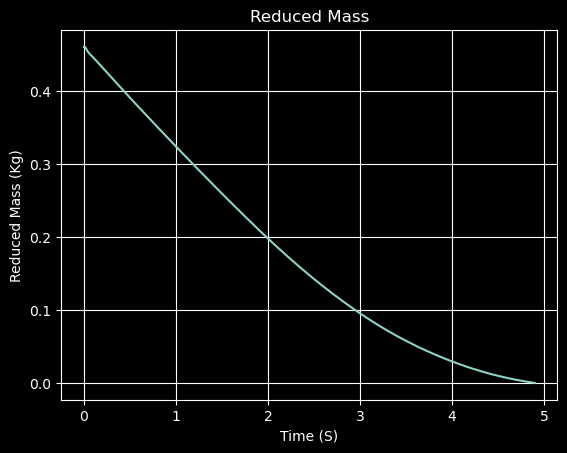


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


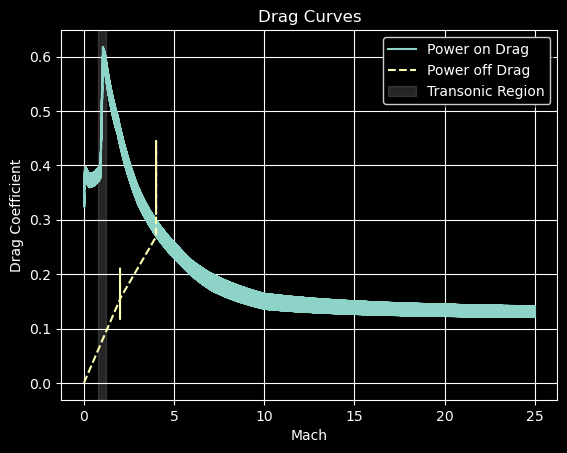


Stability Plots
--------------------


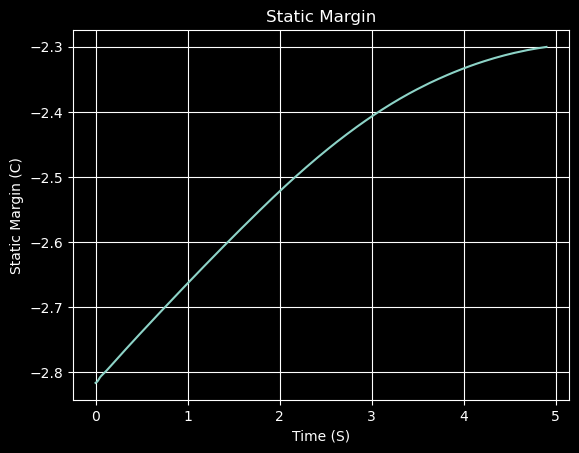

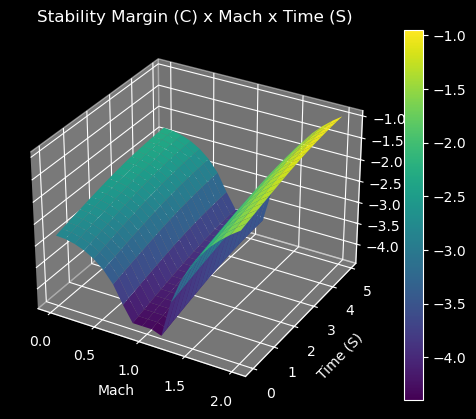


Thrust-to-Weight Plot
----------------------------------------


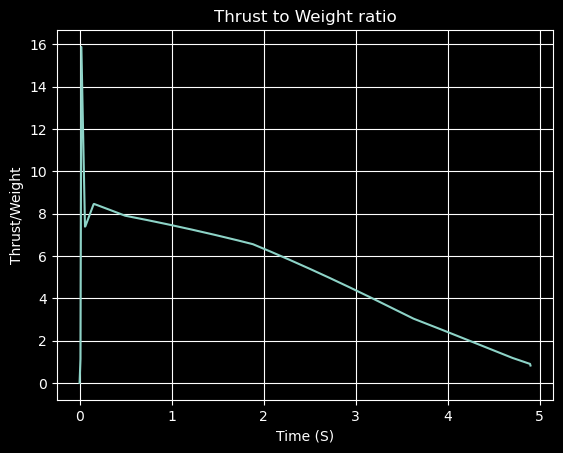

In [8]:
rocket.all_info()

## Flight

Flight Trajectory

- Yellow Line: Altitude (height over time)
- Red Line: Vertical Velocity (speed in the vertical direction)
- Purple Line: Acceleration (rate of change of velocity)
- Teal/Cyan Line: Drag Force (aerodynamic drag acting on the rocket)



Initial Conditions

Initial time: 0.000 s
Position - x: 0.00 m | y: 0.00 m | z: 88.95 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude (quaternions) - e0: 0.707 | e1: 0.000 | e2: 0.000 | e3: -0.707
Euler Angles - Spin φ : -225.00° | Nutation θ: 0.00° | Precession ψ: 135.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s | ω3: 0.00 rad/s
Initial Stability Margin: -2.818 c


Surface Wind Conditions

Frontal Surface Wind Speed: 9.77 m/s
Lateral Surface Wind Speed: 4.38 m/s


Launch Rail

Launch Rail Length: 2 m
Launch Rail Inclination: 90.00°
Launch Rail Heading: 90.00°


Rail Departure State

Rail Departure Time: 0.205 s
Rail Departure Velocity: 14.980 m/s
Rail Departure Stability Margin: -2.788 c
Rail Departure Angle of Attack: 35.621°
Rail Departure Thrust-Weight Ratio: 8.381
Rail Departure Reynolds Number: 9.954e+04


Burn out State

Burn out time: 4.900 s
Altitude at burn out: 270.577 m (ASL) | 181.624 m (AGL)
Rocket speed at burn out: 17.909 m/s
Freestream veloc

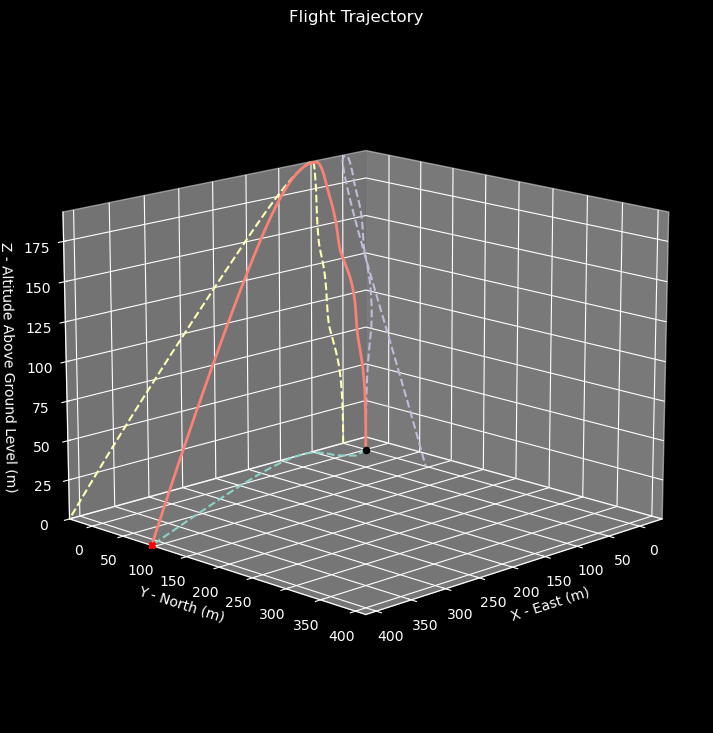



Trajectory Kinematic Plots



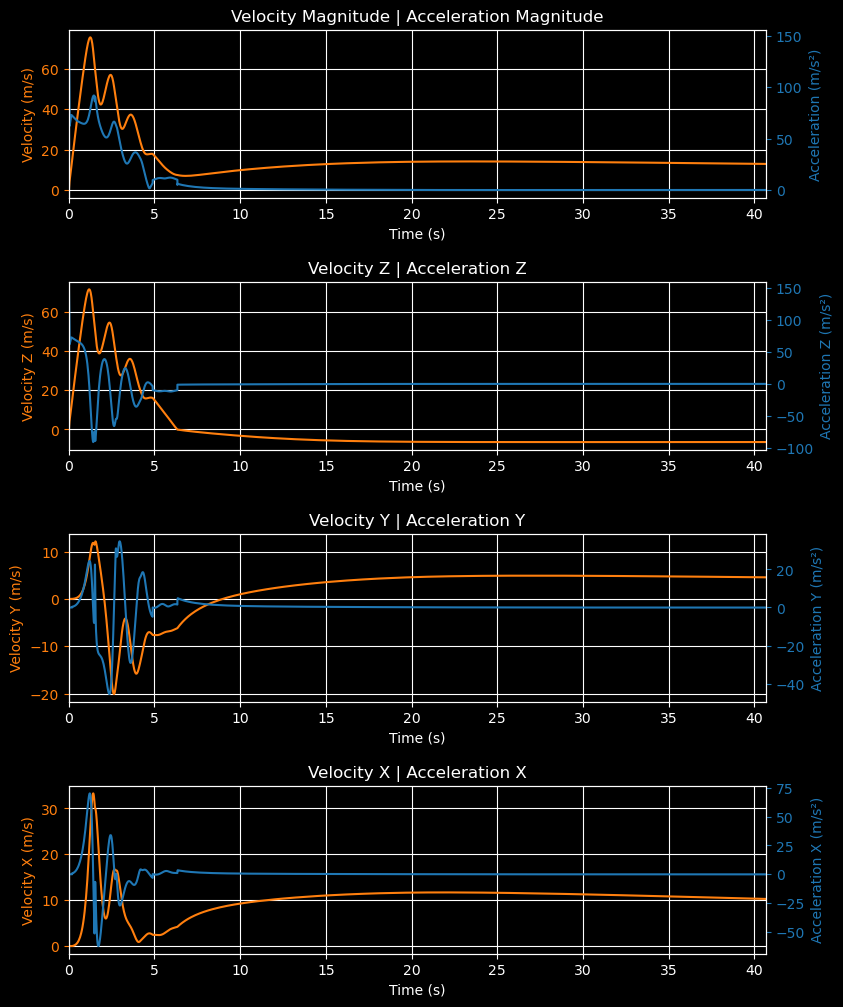



Angular Position Plots



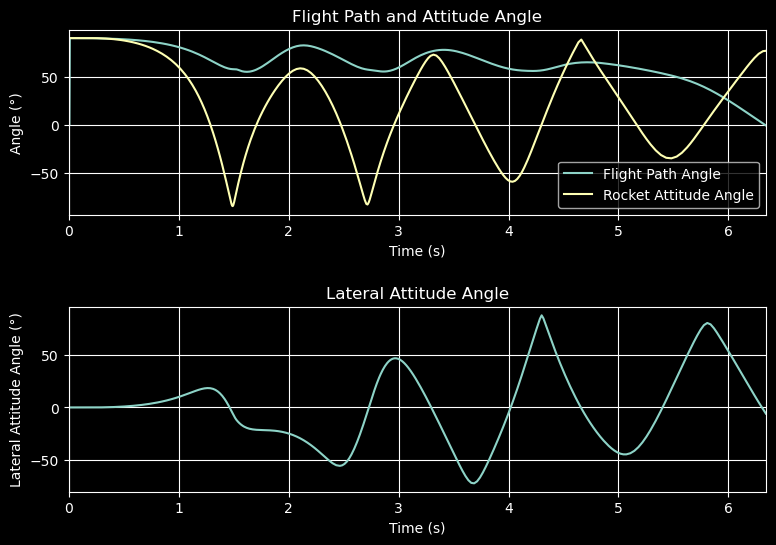



Path, Attitude and Lateral Attitude Angle plots



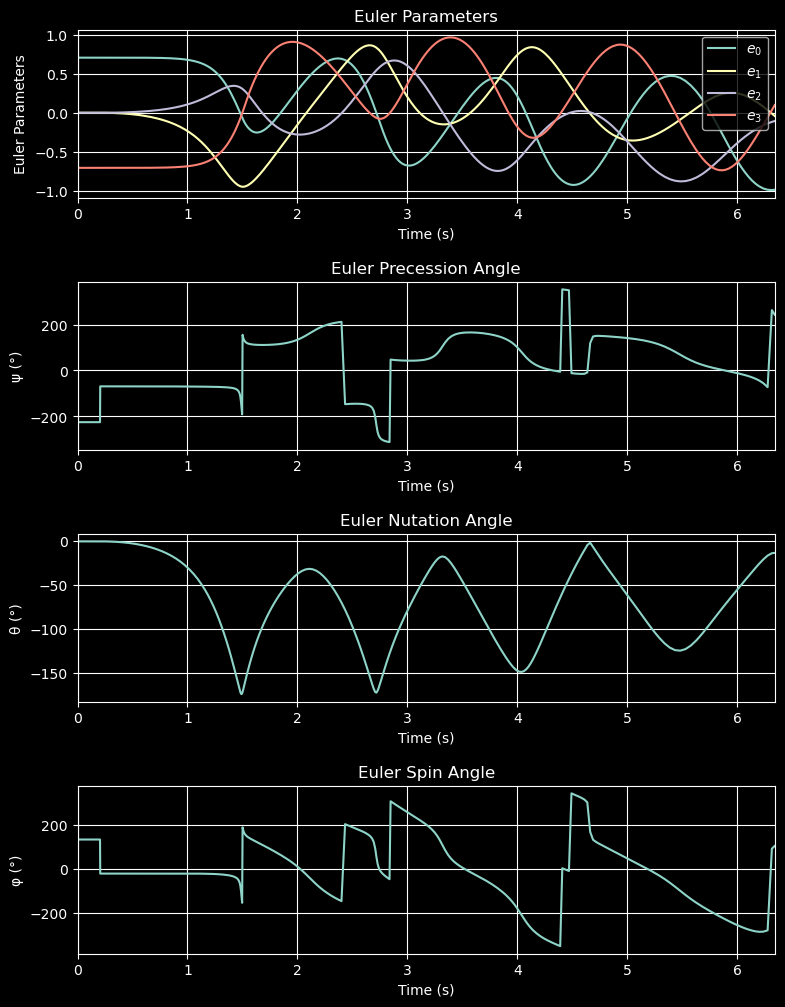



Trajectory Angular Velocity and Acceleration Plots



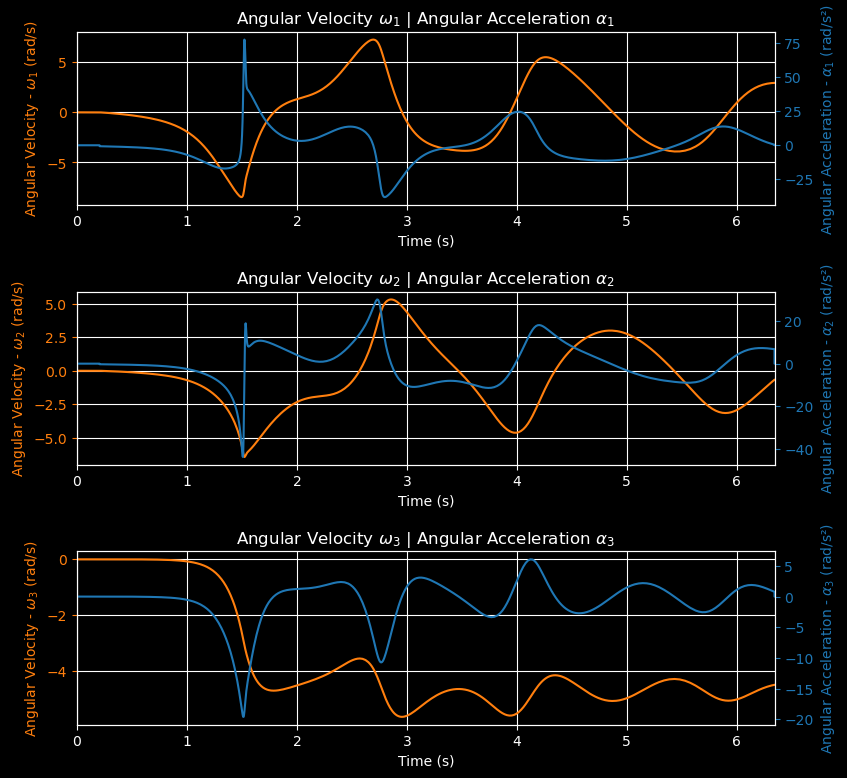



Aerodynamic Forces Plots



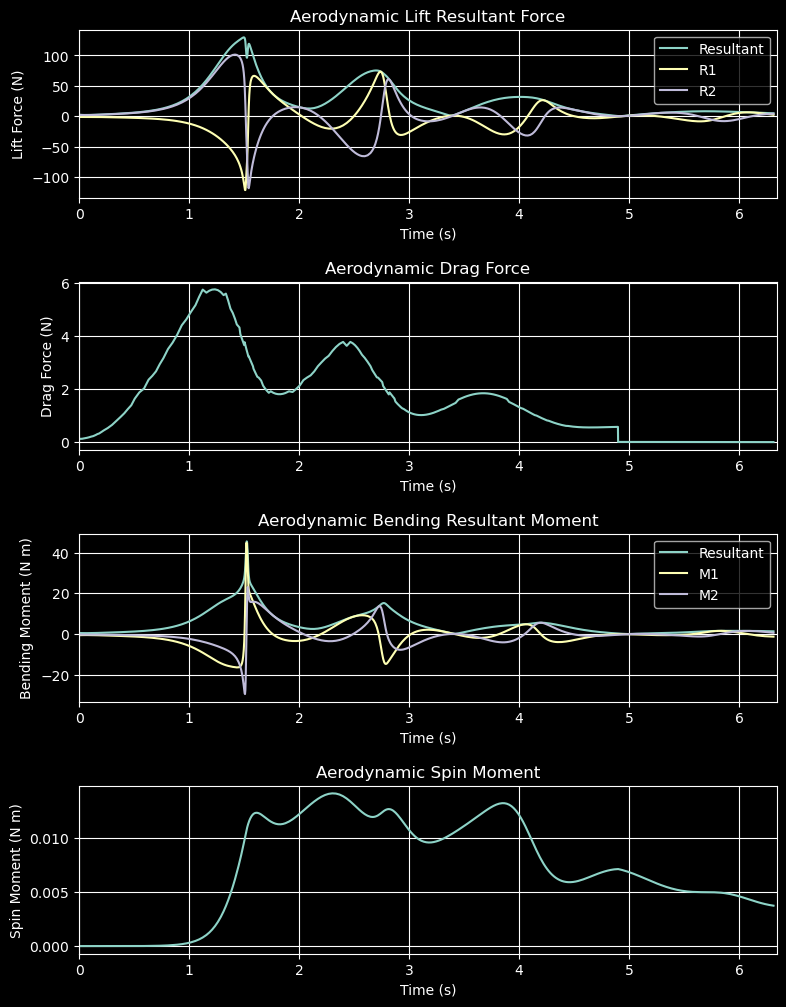



Rail Buttons Forces Plots



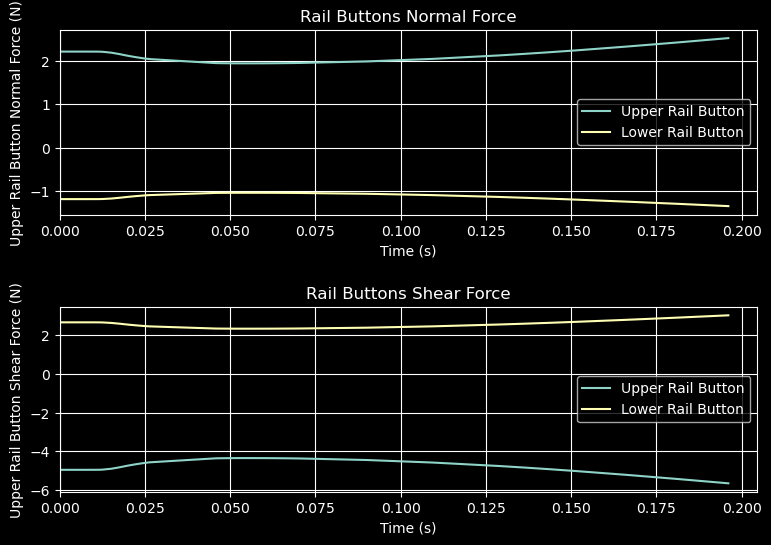



Trajectory Energy Plots



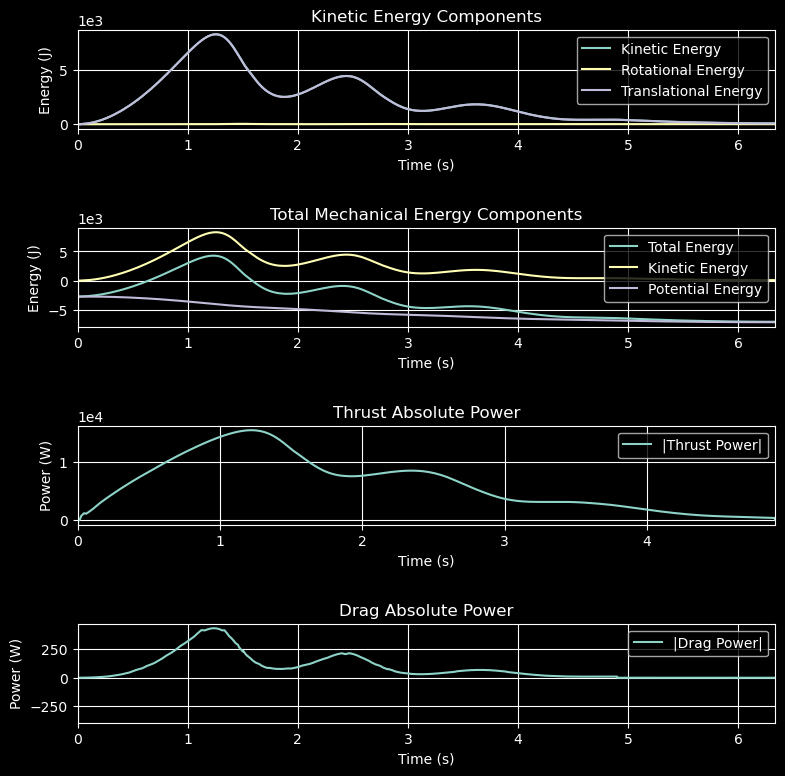



Trajectory Fluid Mechanics Plots



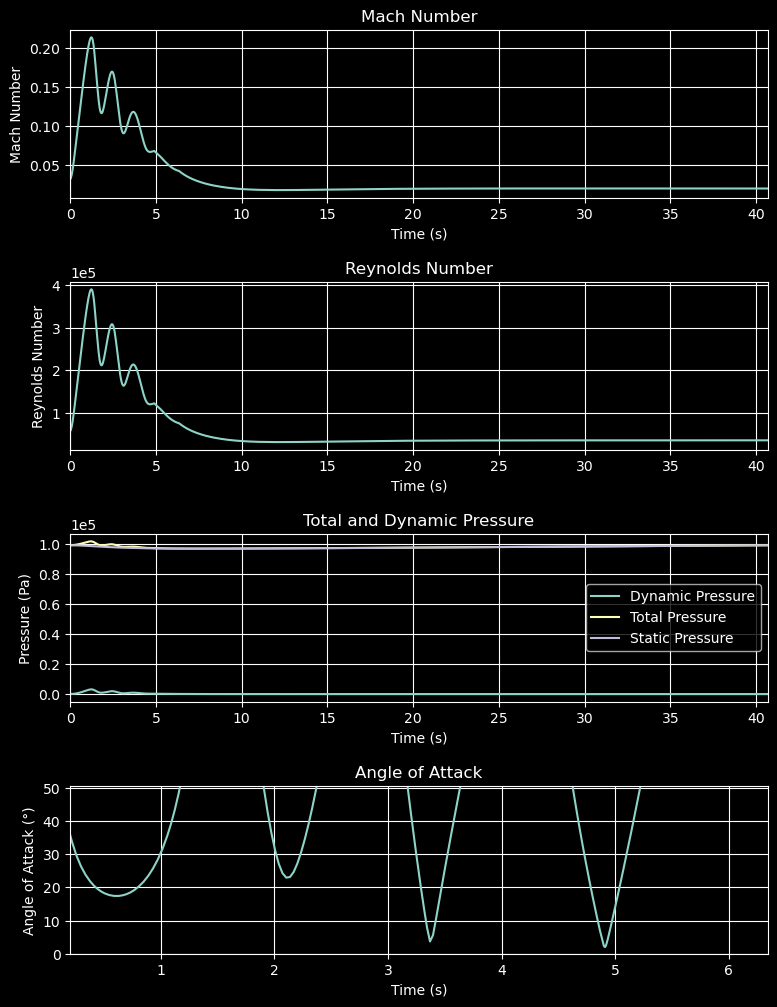



Trajectory Stability and Control Plots



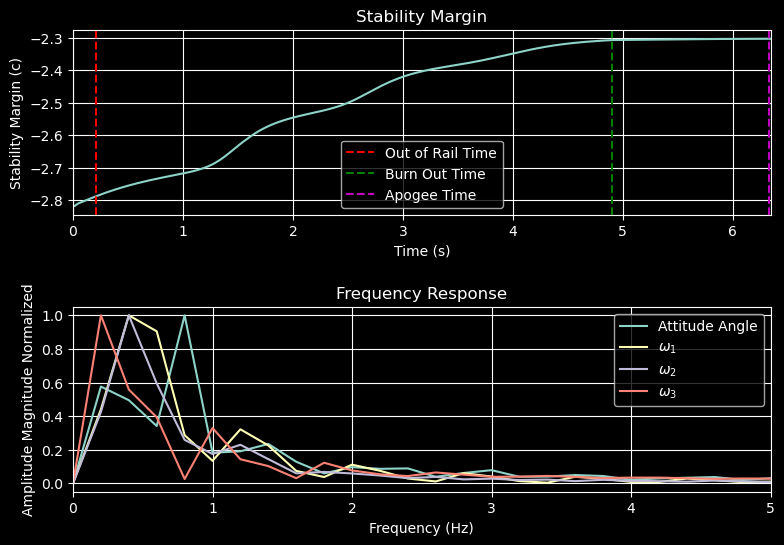



Rocket and Parachute Pressure Plots



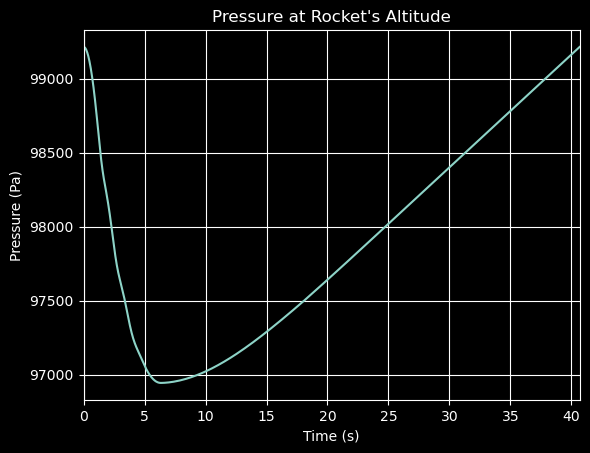


Parachute:  Drogue


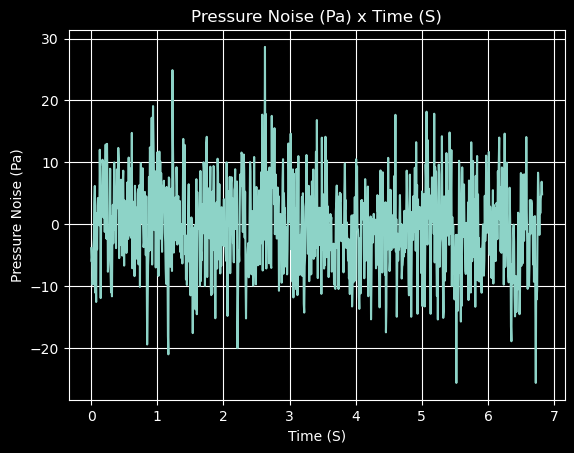

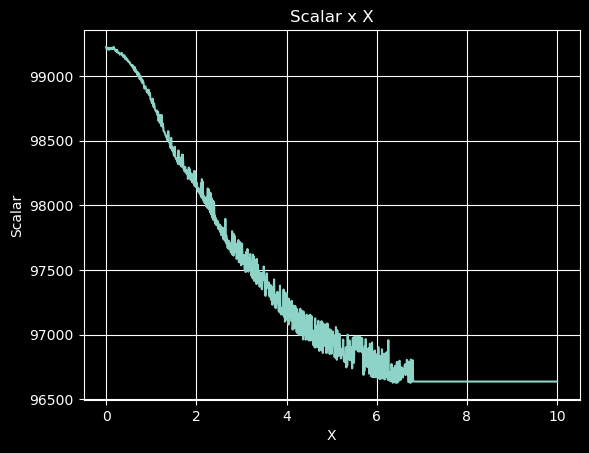

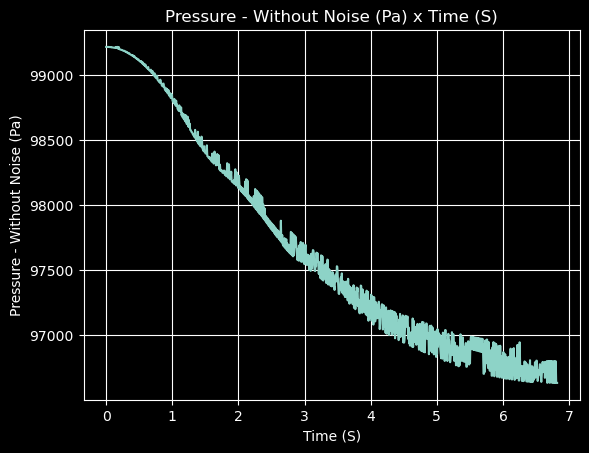


Parachute:  Main


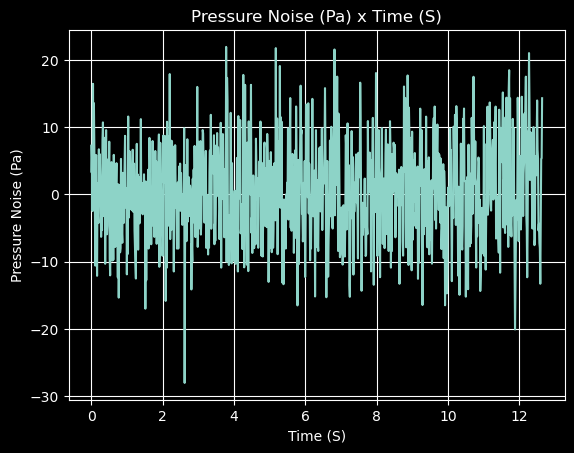

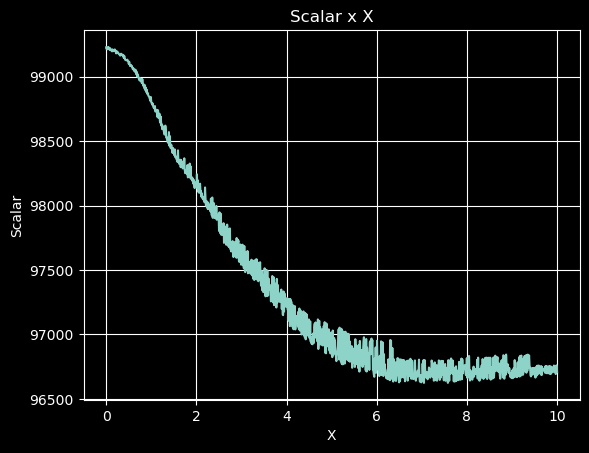

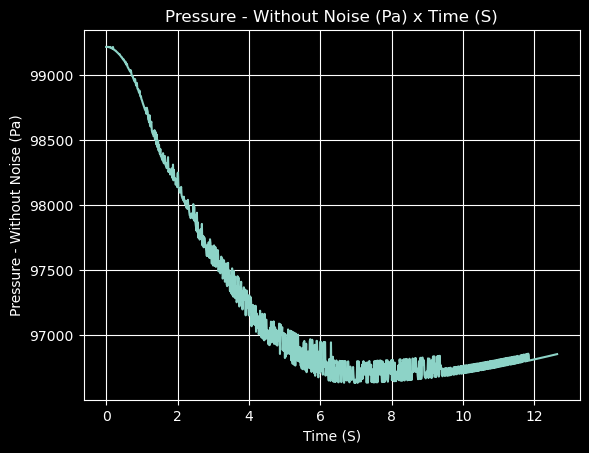

In [16]:
flight = Flight(
    rocket=rocket,
    environment=env,
    rail_length=2,  # meters
    inclination=90,  # launch rail (in degrees)
    heading=90,  # launch rail (in degrees)
)
flight.all_info()

## Export


In [10]:
flight.export_kml("assets/results/Preliminary.kml")

File  assets/results/Preliminary.kml  saved with success!
